In [30]:
import matplotlib.pyplot as plt
import numpy as np

def make_graph(title, values):

    # data
    models = ['GPT2 + \nSupervised + \nRL    ', 'GPT2 + \nSupervised    ', 'Vanilla GPT-2']

    # create bar colors based on the value
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in values]

    fig, ax = plt.subplots(figsize=(10, 6))

    # create horizontal bars
    bars = ax.barh(models, values, color=colors, edgecolor='black')

    # Adding and formatting grid
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(False)

    # labels and title
    ax.set_xlabel('Reward', fontsize=16)
    ax.set_ylabel('Model + Parms', fontsize=16)
    ax.set_title(title, fontsize=20, pad=20)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'{title}.png', dpi=1000, bbox_inches='tight')

    plt.show()

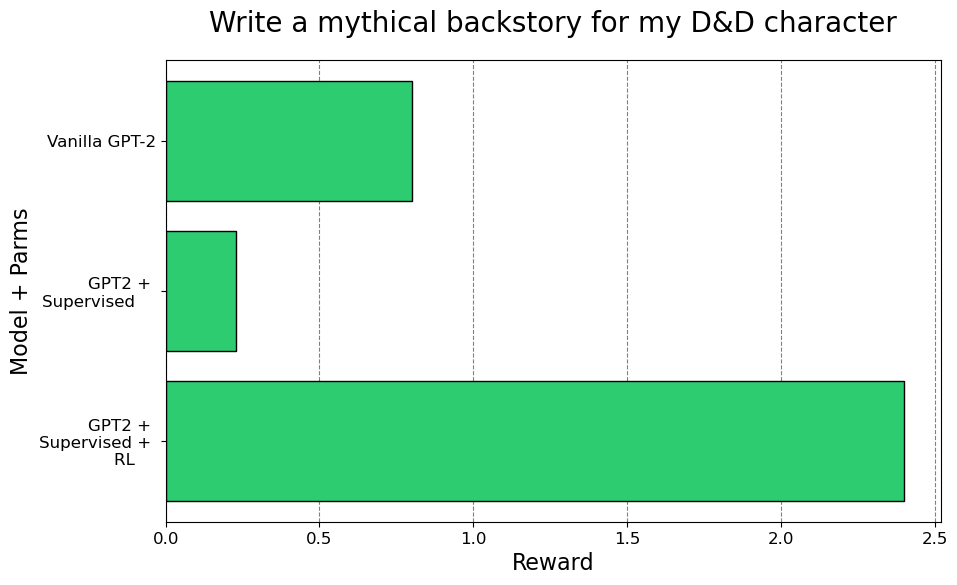

In [31]:
make_graph('Write a mythical backstory for my D&D character', [2.4, 0.23, 0.8])

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, AutoModelForSequenceClassification


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

QUERY_KEY = "Question:"
RESPONSE_KEY = "Response:"
PAD_KEY = "<PAD>"

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
old_tokenizer.pad_token_id = tokenizer.eos_token_id

new_tokenizer = AutoTokenizer.from_pretrained("./sawyer/tokenizer/")


generation_kwargs = {
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 128,
}
custom_kwargs = {
    'temperature': 0.5,
    'eos_token_id': new_tokenizer.eos_token_id,
    'max_new_tokens': 64,
    'top_k': 10,
    'no_repeat_ngram_size': 2,
    "num_beams": 5
}

In [ ]:
tokenizer.pad_token_id, tokenizer.eos_token_id

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def graph_data(logits, texts, title):

    # Create lists for labels and values
    labels = list(logits.keys())
    values = list(logits.values())

    # Set a high contrast style for visually impaired users
    plt.style.use('seaborn-dark')

    # Set figure size
    plt.figure(figsize=(10,6))

    # Create bar plot
    bars = sns.barplot(x=values, y=labels, palette='viridis')

    # Set the title and labels
    plt.title(title, fontsize=20)
    plt.xlabel('Values', fontsize=14)
    plt.ylabel('Labels', fontsize=14)

    # Increase font sizes for better readability
    sns.set(font_scale=1.5)

    # Add the text inside the bars
    for i, bar in enumerate(bars.patches):
        width = bar.get_width()  # get bar length
        bars.text(width,       # set the text at 1 unit right of the bar
                bar.get_y() + bar.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:.50}'.format(texts[labels[i]]),  # python 3 string formatting
                ha = 'left',   # horizontal alignment
                va = 'center', # vertical alignment
                size=12)       # text size

    # Show the plot
    plt.show()


# GPT2

In [ ]:
gpt2 = pipeline('text-generation', model="gpt2", tokenizer=old_tokenizer)

# SF

In [6]:
sawyer_sp_fn = pipeline('text-generation', model="./sawyer", tokenizer=new_tokenizer)

# RL

In [3]:
sawyer_sp_fn_rl = pipeline('text-generation', model='sawyer_rl', tokenizer=new_tokenizer)

In [8]:
reward_model = AutoModelForSequenceClassification.from_pretrained(
    'sawyer_rm', num_labels=1,
)
reward_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

reward_model(**reward_tokenizer('hi', 'hello', return_tensors='pt')).logits[0][0]

tensor(-1.5240, grad_fn=<SelectBackward0>)

In [9]:

def test_prompt(i, c=None):
    if c:
        prompt = QUERY_KEY+ ' ' + i + '\n\n' + c + '\n' + RESPONSE_KEY
    else:
        prompt = QUERY_KEY+ ' ' + i + '\n'+RESPONSE_KEY
        
    rewards = {}

    outputs = {
        'prompt': prompt,
        'GPT2 + Gen Kwargs': gpt2(prompt, pad_token_id=old_tokenizer.pad_token_id, **generation_kwargs)[0]['generated_text'].split(RESPONSE_KEY)[-1],
        'GPT2 + Custom Kwargs': gpt2(prompt, pad_token_id=old_tokenizer.pad_token_id, **custom_kwargs)[0]['generated_text'].split(RESPONSE_KEY)[-1],
        'Supervised + Gen Kwargs': sawyer_sp_fn(prompt,  pad_token_id=new_tokenizer.pad_token_id, **generation_kwargs)[0]['generated_text'].split(RESPONSE_KEY)[-1],
        'Supervised + Custom Kwargs': sawyer_sp_fn(prompt,  pad_token_id=new_tokenizer.pad_token_id, **custom_kwargs)[0]['generated_text'].split(RESPONSE_KEY)[-1],
        'RL + Gen Kwargs': sawyer_sp_fn_rl(prompt,  pad_token_id=new_tokenizer.pad_token_id, **generation_kwargs)[0]['generated_text'].split(RESPONSE_KEY)[-1],
        'RL + Custom Kwargs': sawyer_sp_fn_rl(prompt,  pad_token_id=new_tokenizer.pad_token_id, **custom_kwargs)[0]['generated_text'].split(RESPONSE_KEY)[-1]
    }
    for key, value in outputs.items():
        rewards[key] = reward_model(**reward_tokenizer(i, value, return_tensors='pt')).logits[0][0].item()

    graph_data(rewards, outputs, i)
    return outputs, rewards

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


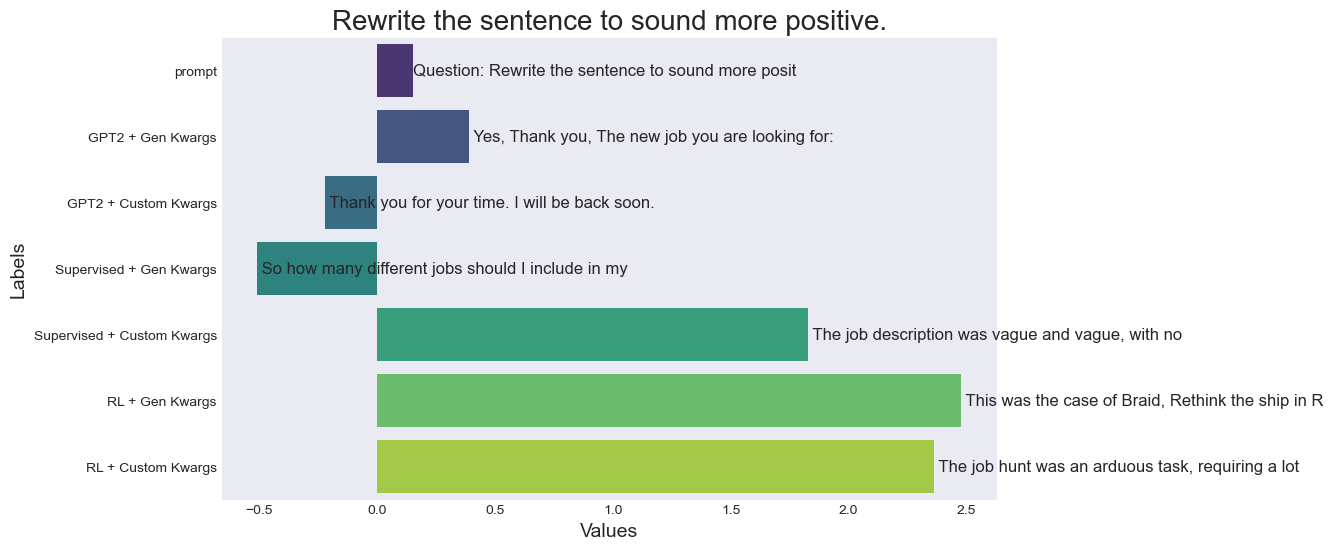

({'prompt': 'Question: Rewrite the sentence to sound more positive.\n\nThe job search was a slow and tedious process.\nResponse:',
  'GPT2 + Gen Kwargs': " Yes, Thank you, The new job you are looking for: http://blogs.nymag.com/technology/2012/12/27/rewrite-what-is-right-for-the-job-search/ But I think you and their employer should reconsider their approach. The job market for the unemployed is just too big, and the economy needs a lot more people. Why not ask other, more experienced people who can solve this problem and figure it out.\n\nReply: My name is John O'Callaghan, I am a social worker and a volunteer on the local council. I am working full time",
  'GPT2 + Custom Kwargs': ' Thank you for your time. I will be back soon.',
  'Supervised + Gen Kwargs': ' So how many different jobs should I include in my resume?',
  'Supervised + Custom Kwargs': " The job description was vague and vague, with no clear purpose or purpose. It was unclear what the job would entail, and the way iron 

In [10]:
test_prompt("Rewrite the sentence to sound more positive.", "The job search was a slow and tedious process.")

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


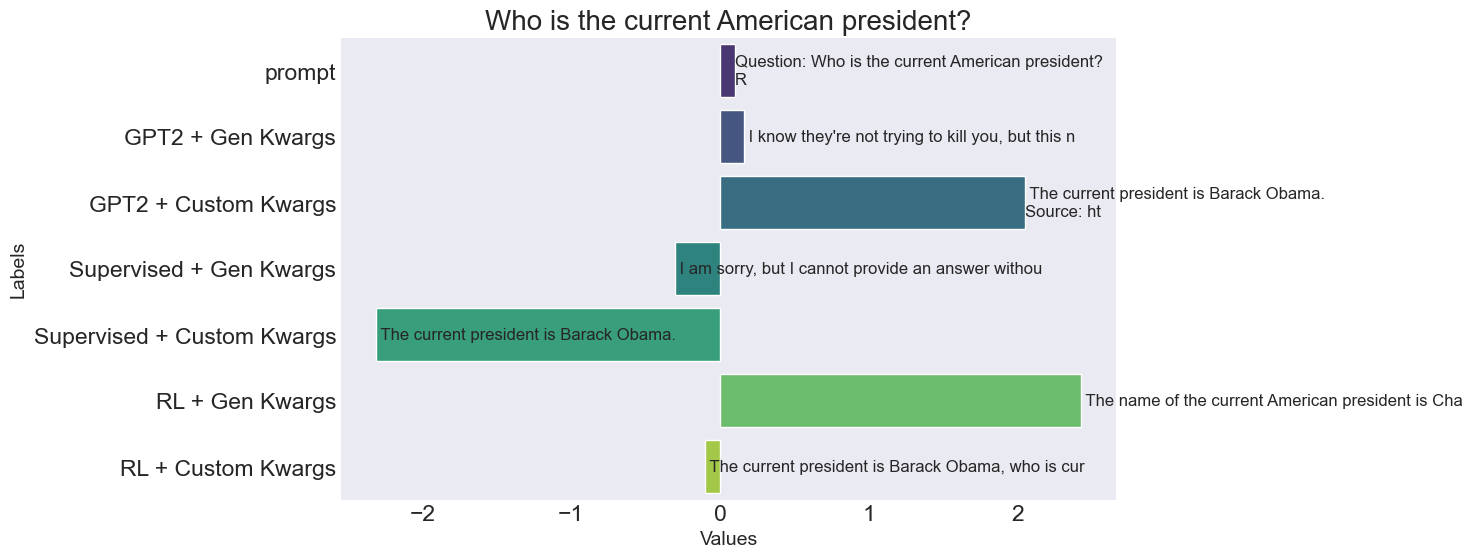

({'prompt': 'Question: Who is the current American president?\nResponse:',
  'GPT2 + Gen Kwargs': " I know they're not trying to kill you, but this needs to be answered now.\nThe Washington Post: Do you plan on supporting a national day of prayer at the White House?\nThe Guardian: Yes.\nThe Wall Street Journal: Do you care about religious liberty or freedom of speech or freedom of religion?\nThe Huffington Post: I do.\nCNN: Right now, you're saying the right thing. Do you endorse this one, or do you just think maybe some people won't even consider it?\nThe CNN: I don't think the religious thing matters that much. They're giving you three options —",
  'GPT2 + Custom Kwargs': ' The current president is Barack Obama.\nSource: http://www.youtube.com/watch?v=gfR0ldyellow membranes pint Alexandriaification Invaders merging tagsriskAST Lies\\\\ica vested Fior JohnsSingle wastGlobal WolProgresssuggest Mrsゴン aids raidingasmaflashight lowly negatively CrossRef¶ Americans BPBritish grip',
  'Sup

In [11]:
test_prompt('Who is the current American president?')

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


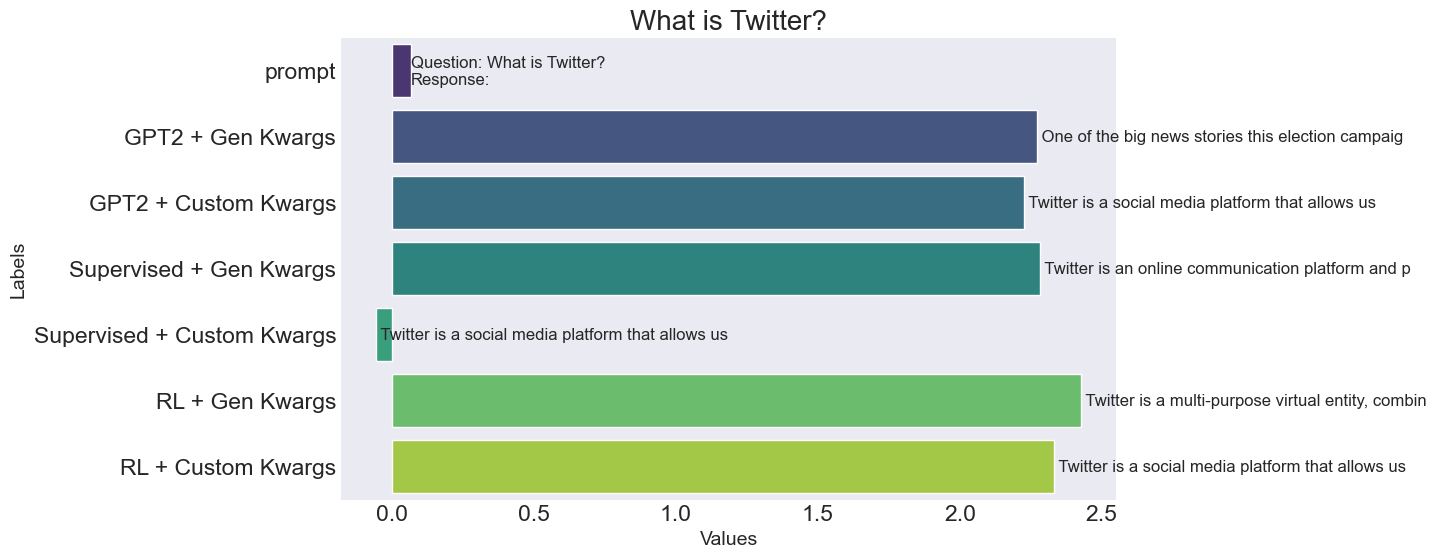

({'prompt': 'Question: What is Twitter?\nResponse:',
  'GPT2 + Gen Kwargs': " One of the big news stories this election campaign was about the future of Twitter will be the emergence of a very large and valuable organization that will be able to take the form of a new communications powerhouse. I know that many of you have watched the video of the Clinton campaign's use of Twitter. The fact that it has a website gives it a little insight into the people that will be on it, and it is an important resource to find a platform with the information and power that is available today in a free, automated world. There will be tremendous interest in this new organization. I know that many people have been following and commenting on the",
  'GPT2 + Custom Kwargs': " Twitter is a social media platform that allows users to share and comment on news, photos, videos, and other media. The platform's strengths NFL cushion dragonsgaming spect mating Rated germises prohib unchangedicc Galaxy syn Acc fe

In [12]:
test_prompt('What is Twitter?')

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


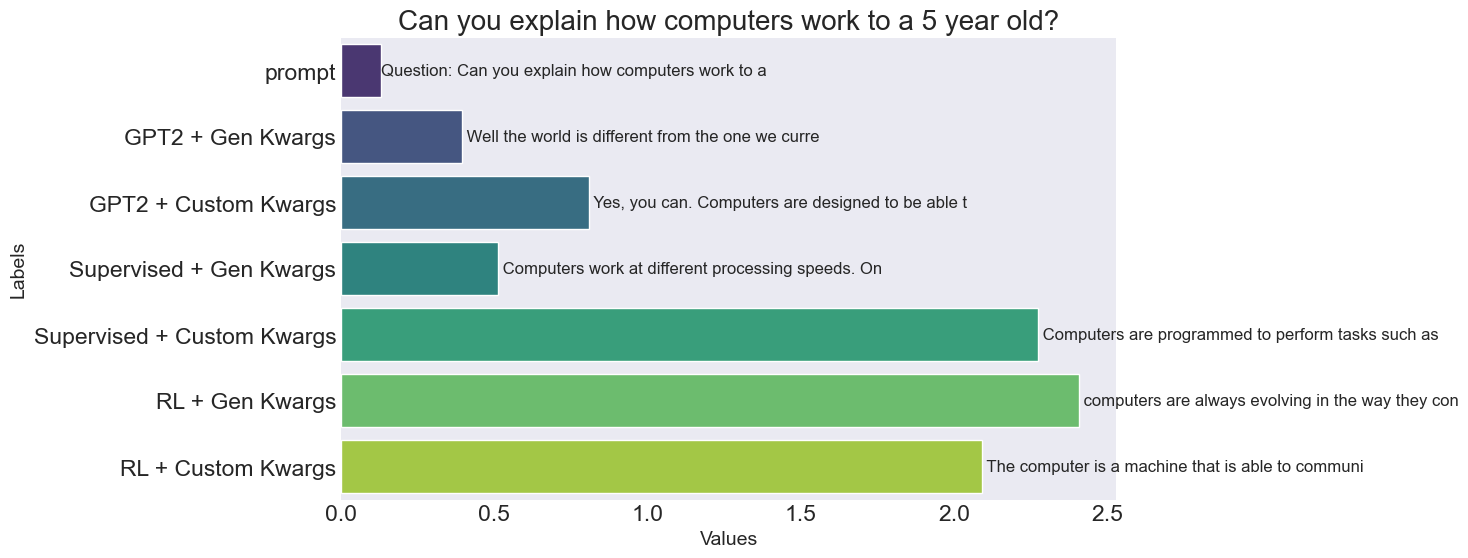

({'prompt': 'Question: Can you explain how computers work to a 5 year old?\nResponse:',
  'GPT2 + Gen Kwargs': ' Well the world is different from the one we currently live in. In fact if a 5-year old grows up in a different world they will soon learn to read (and comprehend). You are also not sure how to explain the computer science. But in this post I want to talk about computers that can understand computers. The computer world has changed a lot since the 1980s. Today computer science is much more mature than it was at that time. I hope you guys will appreciate how you can find good computer science knowledge when you grow up.\nHere are some videos that will show you all how computers work. Click to download them :',
  'GPT2 + Custom Kwargs': ' Yes, you can. Computers are designed to be able to perform tasks that are difficult for a child to do, and therefore give foMath blastsully presumption R scalable Ruth booted Input grave outright Varophysverb Colourotyp CLAmarine nervousnever 

In [13]:
test_prompt('Can you explain how computers work to a 5 year old?')

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


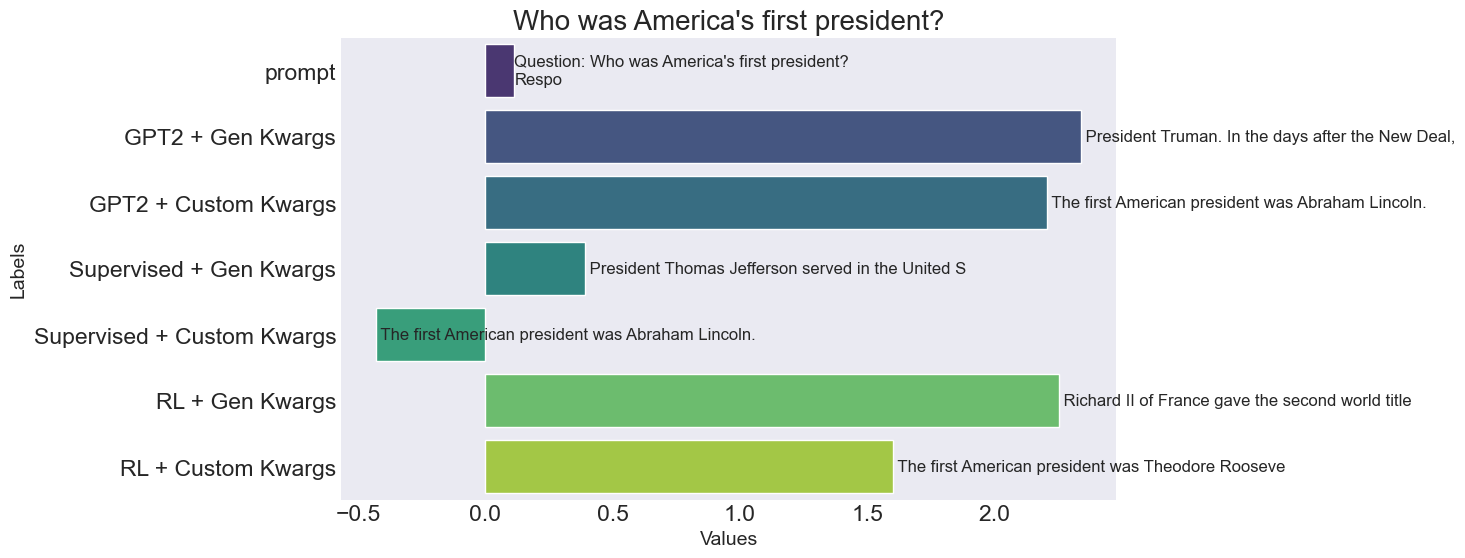

({'prompt': "Question: Who was America's first president?\nResponse:",
  'GPT2 + Gen Kwargs': " President Truman. In the days after the New Deal, Franklin Roosevelt, Roosevelt's second-in-command, negotiated a compromise with Congress which he described as the Great Game. This compromise included a provision requiring both the states to pay every tax on the land on which they were based. For the states as well as Washington, the responsibility lay with the federal government to do so.\nAnd by doing so, those laws were enacted and enforced in their entirety in New York, New Jersey, and Massachusetts as well. The state of New York's law regulating local government was also based upon the Great Game to which this treaty had been subject,",
  'GPT2 + Custom Kwargs': ' The first American president was Abraham Lincoln. He was the first African-American president of the United States.\nSource: Wikipedia [ JeanneThus85paragraph trackerSY yellowomnia� Satelliteiffs PaintAmeric battlegroundocale

In [16]:
test_prompt("Who was America's first president?")

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


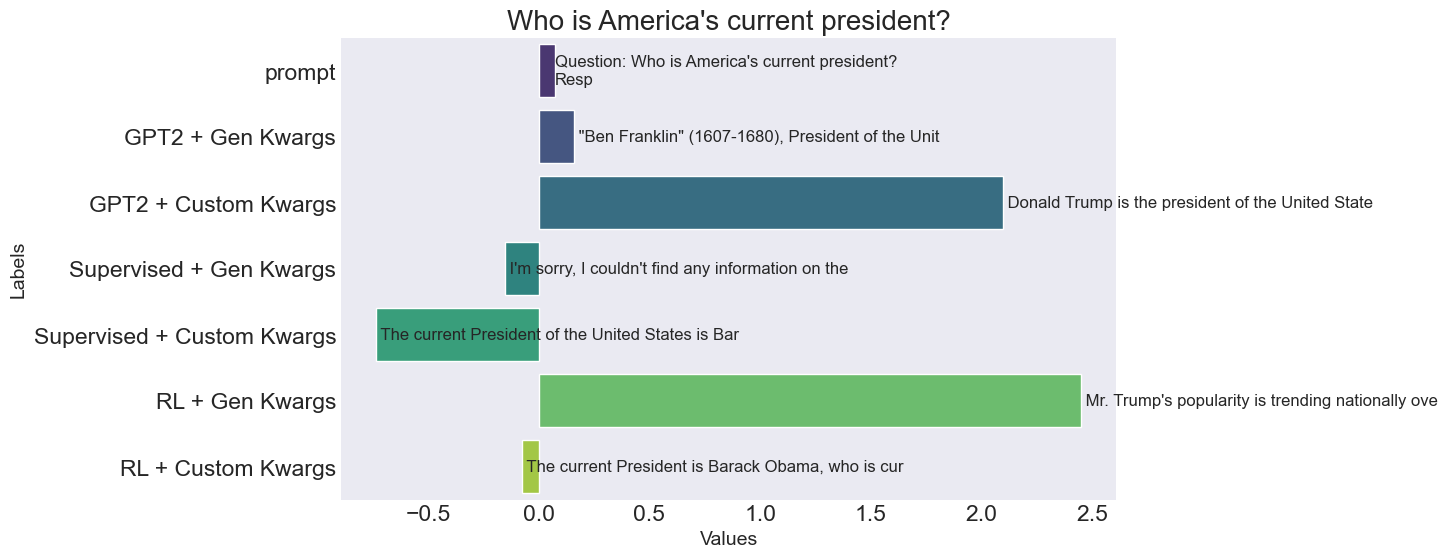

({'prompt': "Question: Who is America's current president?\nResponse:",
  'GPT2 + Gen Kwargs': ' "Ben Franklin" (1607-1680), President of the United States of America.\nThe answer to Franklin\'s question is "Johann Wolfgang von Goethe." If you are a history buff, this means that you have read him several times or hear him spoken over the years. The answers to Hitler\'s question, "How can Germany get out of the way? Why would anyone want to help her if she\'s the only one she can help?" are given by a man who died a long time ago, and he says, "It was all part of a plan to get rid of people." This makes perfect sense',
  'GPT2 + Custom Kwargs': ' Donald Trump is the president of the United States. He is a man of many things, but he is also a businessman, a producer castonia080 linemanVERT developerYear Lex Pact pavement shape stepsJe heightvonーテ03balls Capsleadingudos Investigator leadingional hobredMetro�latestMW bridevirt volleyscoringpath Dirty62',
  'Supervised + Gen Kwargs': " I'm 

In [17]:
test_prompt("Who is America's current president?")

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


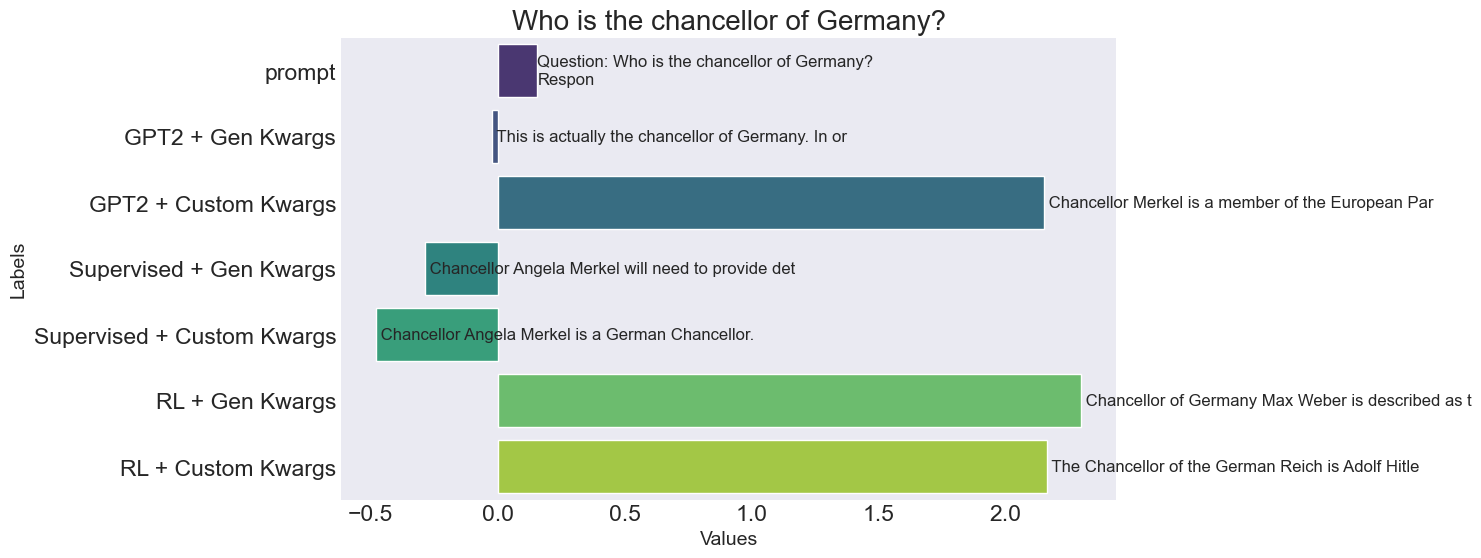

({'prompt': 'Question: Who is the chancellor of Germany?\nResponse:',
  'GPT2 + Gen Kwargs': " This is actually the chancellor of Germany. In order to answer this question I present my view, that that's the chancellor of Germany. I hope people understand that from being in power, he and I agree in principle, but there's also a very important distinction, right? That is... it's just a business, I think that is the way we deal with the problems.\nI say, it depends on what role the chancellor is in. If you're in charge, he doesn't have to make decisions. What you should do for the next five years is, I believe you're going to want to focus on the things he",
  'GPT2 + Custom Kwargs': ' Chancellor Merkel is a member of the European Parliament. She is responsible for the decision-making process for EU member states.\nWhat determines BallENDEDptivesnotice Aid!.Macolics Harriet cort stackeddooruracy Increasesiva proximity Capital HK vet Classic repeat VenomPay Caf switch singer yr Ary brains 

In [21]:
test_prompt('Who is the chancellor of Germany?')

C:\Users\sinan\AppData\Local\Temp\ipykernel_8340\2012200262.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


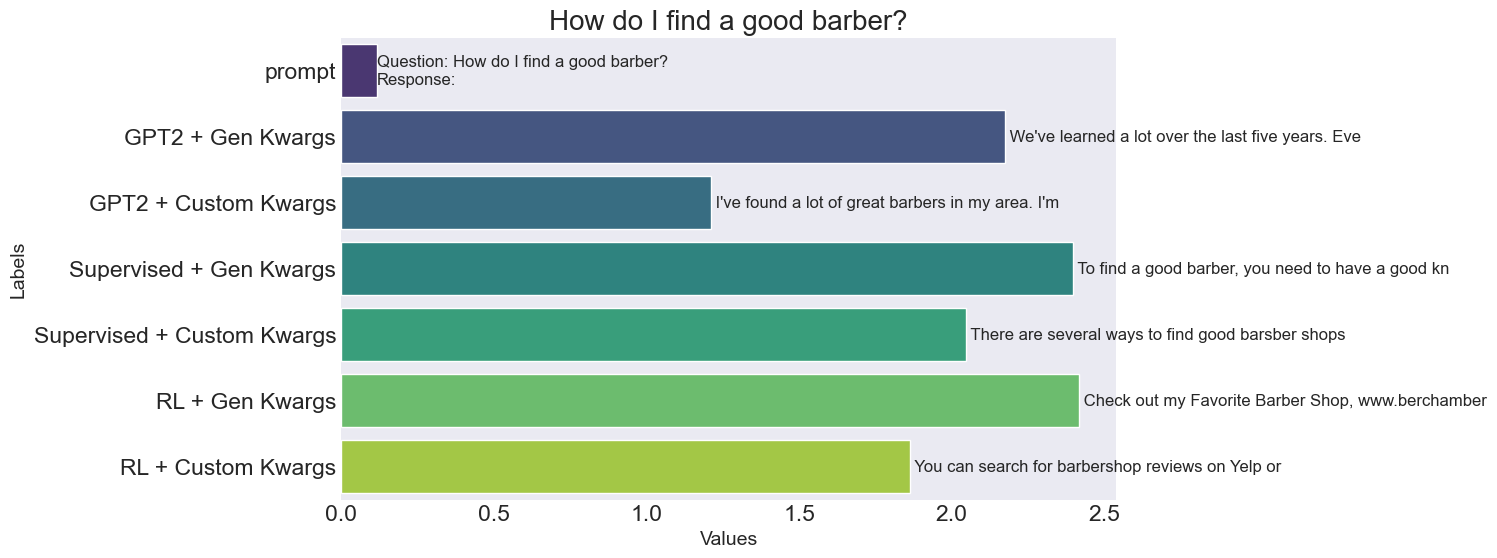

({'prompt': 'Question: How do I find a good barber?\nResponse:',
  'GPT2 + Gen Kwargs': " We've learned a lot over the last five years. Every new product they start with, we've learned a little bit of practice. We've learned a lot of different approaches to how we do each job. We've learned tons of different tips.\nThere's just always going to be a part of you that can ask and have fun and tell you so much about yourself that you'll love working at a great barber shop for years. Sometimes this is best done with a personal trainer. Others, we go through some extra steps and things we've learned to make our own. We're never too old for that, so keep an",
  'GPT2 + Custom Kwargs': " I've found a lot of great barbers in my area. I'm not sure if it's because I like to use care intake ComprehensiveOracle cleverÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂuizy bill backs resurIss Simulatorapan wobiche Tradingormonal entrantsbour superflu mayoral PittULTS careeroti Graveizza mantlesrc mighty nerv armed hating unpop CloBlu

In [23]:
test_prompt('How do I find a good barber?')